# Import Library

In [657]:
import mnist

In [658]:
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [659]:
# mx.set_default_device(mx.gpu)

# GAN Architecture

## Generator 👨🏻‍🎨

In [660]:
def GenBlock(in_dim:int,out_dim:int):
   
    return nn.Sequential(
        nn.Linear(in_dim,out_dim),
        nn.BatchNorm(out_dim, 0.8),
        nn.LeakyReLU(0.2)
    )

In [661]:
class Generator(nn.Module):

    def __init__(self, z_dim:int = 10, im_dim:int = 784, hidden_dim: int = 256):
        super(Generator, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            GenBlock(z_dim, hidden_dim),
            GenBlock(hidden_dim, hidden_dim * 2),
            GenBlock(hidden_dim * 2, hidden_dim * 4),
            GenBlock(hidden_dim * 4, hidden_dim * 8),


            nn.Linear(hidden_dim * 8,im_dim),
        )
        
    def __call__(self, noise):
        x = self.gen(noise)
        return mx.tanh(x)

In [662]:
gen = Generator(100)
gen

Generator(
  (gen): Sequential(
    (layers.0): Sequential(
      (layers.0): Linear(input_dims=100, output_dims=256, bias=True)
      (layers.1): BatchNorm(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
      (layers.2): LeakyReLU()
    )
    (layers.1): Sequential(
      (layers.0): Linear(input_dims=256, output_dims=512, bias=True)
      (layers.1): BatchNorm(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
      (layers.2): LeakyReLU()
    )
    (layers.2): Sequential(
      (layers.0): Linear(input_dims=512, output_dims=1024, bias=True)
      (layers.1): BatchNorm(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
      (layers.2): LeakyReLU()
    )
    (layers.3): Sequential(
      (layers.0): Linear(input_dims=1024, output_dims=2048, bias=True)
      (layers.1): BatchNorm(2048, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
      (layers.2): LeakyReLU()
    )
    (layers.4): Linear(input_dims=2048, output_dims

In [663]:
# make 2D noise with shape n_samples x z_dim
def get_noise(n_samples:list[int], z_dim:int)->list[int]:
    return mx.random.normal(shape=(n_samples, z_dim))

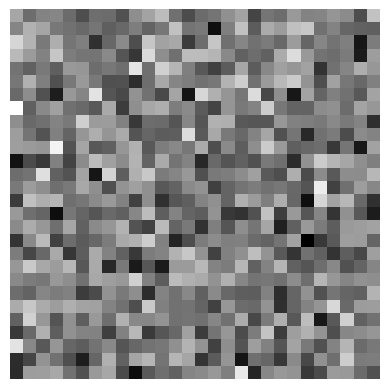

In [664]:
img = get_noise(28,28)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

## Discriminator 🕵🏻‍♂️

In [665]:
def DisBlock(in_dim:int,out_dim:int):
    return nn.Sequential(
        nn.Linear(in_dim,out_dim),
        nn.LeakyReLU(negative_slope=0.2),
    )

In [666]:
class Discriminator(nn.Module):

    def __init__(self,im_dim:int = 784, hidden_dim:int = 256):
        super(Discriminator, self).__init__()

        self.disc = nn.Sequential(
            DisBlock(im_dim, hidden_dim * 4),
            DisBlock(hidden_dim * 4, hidden_dim * 2),
            DisBlock(hidden_dim * 2, hidden_dim),
            
            nn.Dropout(0.3),
            nn.Linear(hidden_dim,1),
            # nn.Sigmoid()
        )
        
    def __call__(self, noise):
        x = noise + 1.0
        x = self.disc(noise)
        out = mx.log(mx.softmax(x)) 
        return out

In [667]:
disc = Discriminator()
disc

Discriminator(
  (disc): Sequential(
    (layers.0): Sequential(
      (layers.0): Linear(input_dims=784, output_dims=1024, bias=True)
      (layers.1): LeakyReLU()
    )
    (layers.1): Sequential(
      (layers.0): Linear(input_dims=1024, output_dims=512, bias=True)
      (layers.1): LeakyReLU()
    )
    (layers.2): Sequential(
      (layers.0): Linear(input_dims=512, output_dims=256, bias=True)
      (layers.1): LeakyReLU()
    )
    (layers.3): Dropout(p=0.30000000000000004)
    (layers.4): Linear(input_dims=256, output_dims=1, bias=True)
  )
)

# Model Training 🏋🏻‍♂️

### Losses

#### Discriminator Loss

In [668]:
def disc_loss(gen, disc, real, num_images, z_dim):
    
    noise =  mx.array(get_noise(num_images, z_dim))
    fake_images = gen(noise)
        
    fake_disc = disc(fake_images)
    
    fake_labels = mx.zeros((fake_images.shape[0],1))
        
    fake_loss = nn.losses.binary_cross_entropy(fake_disc,fake_labels)
    
    real_disc = disc(real)
    real_labels = mx.ones((real.shape[0],1))

    real_loss = nn.losses.binary_cross_entropy(real_disc,real_labels)

    disc_loss = (fake_loss + real_loss) / 2

    return disc_loss

#### Generator Loss

In [669]:
def gen_loss(gen, disc, num_images, z_dim):

    noise = mx.array(get_noise(num_images, z_dim))
    
    fake_images = gen(noise)
    fake_disc = disc(fake_images)

    fake_labels = mx.ones((fake_images.shape[0],1))
            
    gen_loss = nn.losses.binary_cross_entropy(fake_disc,fake_labels)

    return gen_loss

In [670]:
# Get only the training images
train_images,*_ = map(np.array, mnist.mnist())

In [671]:
# Normalize the images to fall between -1,1
train_images = train_images * 2.0 - 1.0

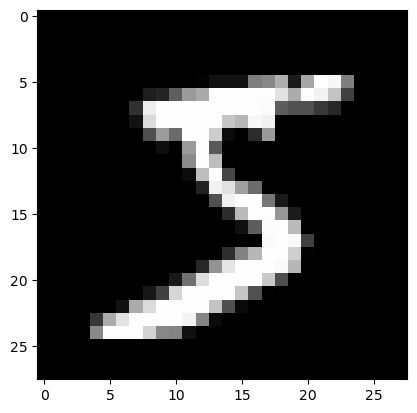

In [672]:
plt.imshow(train_images[0].reshape(28,28),cmap='gray')

In [673]:
def batch_iterate(batch_size: int, ipt: list[int])-> list[int]:
    perm = np.random.permutation(len(ipt))
    for s in range(0, len(ipt), batch_size):
        ids = perm[s : s + batch_size]
        yield ipt[ids]

In [674]:
def show_images(imgs:list[int],num_imgs:int = 25):
    if (imgs.shape[0] > 0): 
        fig,axes = plt.subplots(5, 5, figsize=(5, 5))
        
        for i, ax in enumerate(axes.flat):
            img = mx.array(imgs[i]).reshape(28,28)
            ax.imshow(img,cmap='gray')
            ax.axis('off')
        plt.show()

### show first batch of images

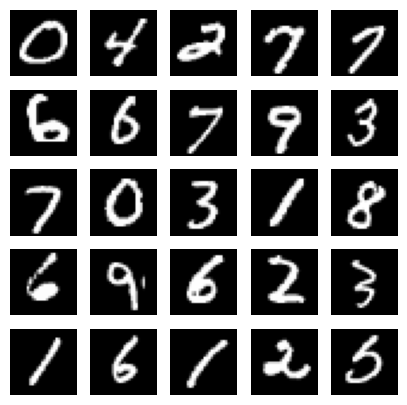

In [675]:
X = batch_iterate(25, train_images)
for x in X:  
    show_images(x)
    break

### Training Cycle

In [676]:
lr = 1e-4
z_dim = 128

gen = Generator(z_dim)
mx.eval(gen.parameters())
gen_opt = optim.Adam(learning_rate=lr, betas=[0.5, 0.999]) #,betas=[0.5, 0.9]

disc = Discriminator()
mx.eval(disc.parameters())
disc_opt = optim.Adam(learning_rate=lr, betas=[0.5, 0.999])

  0%|          | 1/200 [00:05<18:01,  5.43s/it]

Losses D=array(2.28961, dtype=float32) G=array(5.5491, dtype=float32)


  1%|          | 2/200 [00:10<17:20,  5.26s/it]

Losses D=array(2.28963, dtype=float32) G=array(5.5491, dtype=float32)


  2%|▏         | 3/200 [00:15<17:08,  5.22s/it]

Losses D=array(2.28957, dtype=float32) G=array(5.5491, dtype=float32)


  2%|▏         | 4/200 [00:20<16:55,  5.18s/it]

Losses D=array(2.28956, dtype=float32) G=array(5.5491, dtype=float32)


  2%|▎         | 5/200 [00:26<17:02,  5.24s/it]

Losses D=array(2.28958, dtype=float32) G=array(5.5491, dtype=float32)


  3%|▎         | 6/200 [00:31<16:52,  5.22s/it]

Losses D=array(2.28962, dtype=float32) G=array(5.5491, dtype=float32)


  4%|▎         | 7/200 [00:36<16:38,  5.18s/it]

Losses D=array(2.28961, dtype=float32) G=array(5.5491, dtype=float32)


  4%|▍         | 8/200 [00:41<16:49,  5.26s/it]

Losses D=array(2.28955, dtype=float32) G=array(5.5491, dtype=float32)


  4%|▍         | 9/200 [00:47<16:56,  5.32s/it]

Losses D=array(2.2896, dtype=float32) G=array(5.5491, dtype=float32)


  5%|▌         | 10/200 [00:52<17:03,  5.39s/it]

Losses D=array(2.28964, dtype=float32) G=array(5.5491, dtype=float32)


  6%|▌         | 11/200 [00:58<17:03,  5.42s/it]

Losses D=array(2.28956, dtype=float32) G=array(5.54911, dtype=float32)


  6%|▌         | 12/200 [01:03<16:44,  5.35s/it]

Losses D=array(2.28952, dtype=float32) G=array(5.5491, dtype=float32)


  6%|▋         | 13/200 [01:08<16:26,  5.28s/it]

Losses D=array(2.28963, dtype=float32) G=array(5.5491, dtype=float32)


  7%|▋         | 14/200 [01:13<16:11,  5.23s/it]

Losses D=array(2.28959, dtype=float32) G=array(5.5491, dtype=float32)


  8%|▊         | 15/200 [01:19<16:17,  5.28s/it]

Losses D=array(2.2896, dtype=float32) G=array(5.5491, dtype=float32)


  8%|▊         | 16/200 [01:24<16:18,  5.32s/it]

Losses D=array(2.28965, dtype=float32) G=array(5.5491, dtype=float32)


  8%|▊         | 17/200 [01:29<16:12,  5.31s/it]

Losses D=array(2.28969, dtype=float32) G=array(5.54911, dtype=float32)


  9%|▉         | 18/200 [01:35<16:05,  5.31s/it]

Losses D=array(2.28959, dtype=float32) G=array(5.5491, dtype=float32)


 10%|▉         | 19/200 [01:40<15:58,  5.30s/it]

Losses D=array(2.28961, dtype=float32) G=array(5.54911, dtype=float32)


 10%|█         | 20/200 [01:45<15:47,  5.26s/it]

Losses D=array(2.28956, dtype=float32) G=array(5.54911, dtype=float32)


 10%|█         | 21/200 [01:50<15:35,  5.23s/it]

Losses D=array(2.2896, dtype=float32) G=array(5.54911, dtype=float32)
Step 21: Generator loss: array(5.54911, dtype=float32), discriminator loss: array(2.77676, dtype=float32)


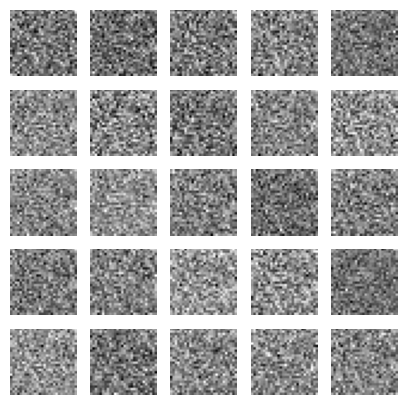

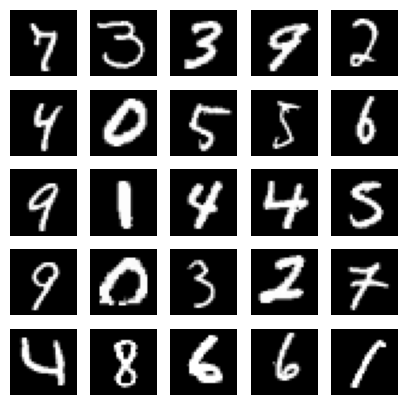

 11%|█         | 22/200 [01:56<15:59,  5.39s/it]

Losses D=array(2.28963, dtype=float32) G=array(5.5491, dtype=float32)


 12%|█▏        | 23/200 [02:01<15:38,  5.30s/it]

Losses D=array(2.28961, dtype=float32) G=array(5.5491, dtype=float32)


 12%|█▏        | 24/200 [02:06<15:28,  5.28s/it]

Losses D=array(2.28957, dtype=float32) G=array(5.5491, dtype=float32)


 12%|█▎        | 25/200 [02:12<15:15,  5.23s/it]

Losses D=array(2.28959, dtype=float32) G=array(5.54911, dtype=float32)


 13%|█▎        | 26/200 [02:17<15:09,  5.23s/it]

Losses D=array(2.28964, dtype=float32) G=array(5.54911, dtype=float32)


 13%|█▎        | 26/200 [02:19<15:36,  5.38s/it]


KeyboardInterrupt: 

In [679]:
# Set your parameters
n_epochs = 200
display_step = 5000
cur_step = 0

batch_size = 128

D_loss_grad = nn.value_and_grad(disc, disc_loss)
G_loss_grad = nn.value_and_grad(gen, gen_loss)


for epoch in tqdm(range(n_epochs)):

    for real in batch_iterate(batch_size, train_images):
                
        # TODO Train Discriminator
        D_loss,D_grads = D_loss_grad(gen, disc,mx.array(real), batch_size, z_dim)

        # Update optimizer
        disc_opt.update(disc, D_grads)
        
        # Update gradients
        mx.eval(disc.parameters(), disc_opt.state)

        # TODO Train Generator
        G_loss,G_grads = G_loss_grad(gen, disc, batch_size, z_dim)
        
        # Update optimizer
        gen_opt.update(gen, G_grads)
        
        # Update gradients
        mx.eval(gen.parameters(), gen_opt.state)        
        
        if (cur_step + 1) % display_step == 0:
            print(f"Step {epoch}: Generator loss: {G_loss}, discriminator loss: {D_loss}")
            fake_noise = mx.array(get_noise(batch_size, z_dim))
            fake = gen(fake_noise)
            show_images(fake)
            show_images(real)
        cur_step += 1

    print('Losses D={0} G={1}'.format(D_loss,G_loss))